In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

## 1. Open datasets
a. Quote data set
(only quotes whose main speaker is part of a 2015-2020 movie crew)

In [23]:
df_quotes = pd.DataFrame()
start_year = 2015
end_year = 2020
for year in range(start_year,end_year + 1):
    df_quotes = pd.concat((df_quotes,pd.read_csv(f"../dataGitIgnore/mergedData/movie_{year}_crew_quotes.csv.gz")))

b. Movie data set

In [58]:
df_movies = pd.read_csv("../moviePreprocessing/movie_data_2015_2020.csv")
df_movies["Total Gross"] = pd.to_numeric(df_movies["Total Gross"].apply(lambda x:x[1:].replace(",","")))

In [59]:
#keep relevant years
df_movies = df_movies[(df_movies["startYear"]>= start_year )&(df_movies["startYear"]<=end_year)]
#sort by Total gross
df_movies = df_movies.sort_values(["Total Gross"],ascending=False)

## 3. Merge data sets

In [60]:
df = pd.merge(df_quotes,df_movies,how="inner",left_on="speaker",right_on="primaryName")

## 4. Compute and store number of days to release for each quote

In [61]:
df["Release_date_f"] = df["Release Date"]+", "+df["startYear"].astype(int).astype(str)
df["Release_date_f"] = pd.to_datetime(df["Release_date_f"])
df["date"] = df["date"].values.astype('datetime64[D]')
df["date_diff"] = (df["Release_date_f"] - df["date"]).dt.days
df = df[(df["startYear"]>= start_year )&(df["startYear"]<=end_year)]
df.head()

,Unnamed: 0_x,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,Release_date_f,date_diff
0,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Hela""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0127536,tt0167260,tt2334873",2017-11-03,954
1,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Valka""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0127536,tt0167260,tt2334873",2019-02-22,1430
2,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Lou""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0127536,tt0167260,tt2334873",2018-06-08,1171
3,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Florence Zimmerman""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0127536,tt0167260,tt2334873",2018-09-21,1276
4,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Carol Aird""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0127536,tt0167260,tt2334873",2015-11-20,240


## 5. Aggregation: count per movie per date_diff

In [67]:
df_agg = df.groupby(["primaryTitle","date_diff"],as_index=False).agg({'primaryTitle': 'first', 'date_diff': 'first','numOccurrences': 'count'})
df_agg.head()

,primaryTitle,date_diff,numOccurrences
0,10 Cloverfield Lane,-1497,1
1,10 Cloverfield Lane,-1490,3
2,10 Cloverfield Lane,-1488,1
3,10 Cloverfield Lane,-1483,3
4,10 Cloverfield Lane,-1482,1


## 6. Press activity around release date

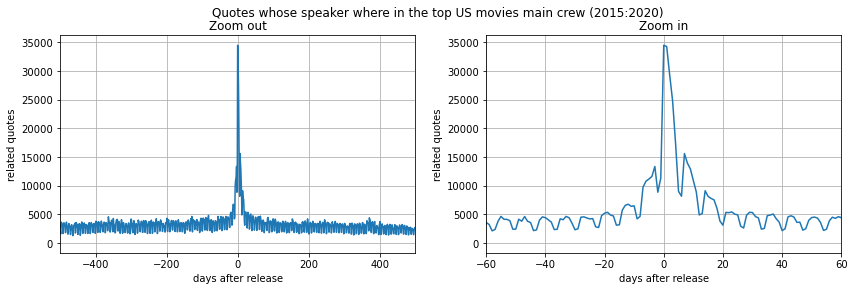

In [99]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
df_agg_tot = df_agg.groupby("date_diff").sum()[["numOccurrences"]]
df_agg_tot = df_agg_tot.reset_index()
sb.lineplot(x="date_diff",y="numOccurrences",data=df_agg_tot)
plt.xlabel("days after release")
plt.ylabel("related quotes")
plt.title("Zoom out")
plt.grid()
plt.xlim(-500,500)

plt.subplot(1,2,2)
sb.lineplot(x="date_diff",y="numOccurrences",data=df_agg_tot)
plt.xlabel("days after release")
plt.ylabel("related quotes")
plt.grid()
plt.xlim(-60,60)
plt.title("Zoom in")
plt.suptitle(f"Quotes whose speaker where in the top US movies main crew ({start_year}:{end_year})")
plt.savefig("quotes_around_release.pdf")

## 7 Correlation Box office - quotes counts

In [95]:
df_agg_movie = df[(df["date_diff"].abs()<10)].groupby(["primaryTitle"],as_index=False).agg({'primaryTitle': 'first', 'Total Gross': 'first','numOccurrences': 'count','Year':'first'})
df_agg_movie.head()

,primaryTitle,Total Gross,numOccurrences,Year
0,10 Cloverfield Lane,72082998,12,2016.0
1,12 Strong,45819713,486,2018.0
2,13 Hours,52853219,9,2016.0
3,1917,159227644,383,2020.0
4,2.0,4152000,242,2018.0


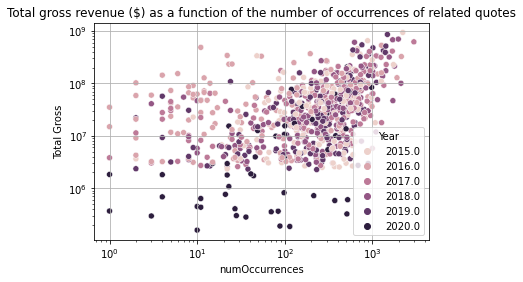

In [98]:
sb.scatterplot(x="numOccurrences",y="Total Gross",data=df_agg_movie,hue="Year")
plt.yscale("log")
plt.xscale("log")
plt.title("Total gross revenue ($) as a function of the number of occurrences of related quotes")
plt.savefig("gross_vs_occurrences.pdf")
plt.grid()
